In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('//content/gdrive/My Drive/Colab Notebooks/')

In [0]:
#export
from exp.nb_06 import *

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [1.1599053451695394, tensor(0.6230, device='cuda:0')]
valid: [0.1903933349609375, tensor(0.9405, device='cuda:0')]
train: [0.16944488053469314, tensor(0.9475, device='cuda:0')]
valid: [0.10619793701171874, tensor(0.9671, device='cuda:0')]
CPU times: user 4.32 s, sys: 1.61 s, total: 5.93 s
Wall time: 8.17 s


## BATCH NORM

### custom

In [0]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.2704393052563225, tensor(0.9157, device='cuda:0')]
valid: [0.12581014404296875, tensor(0.9619, device='cuda:0')]


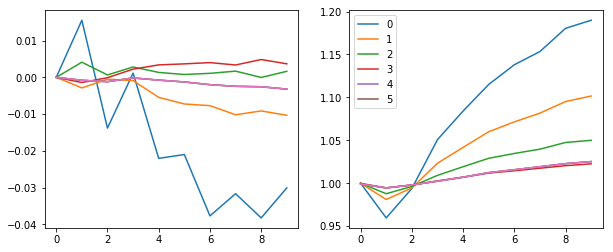

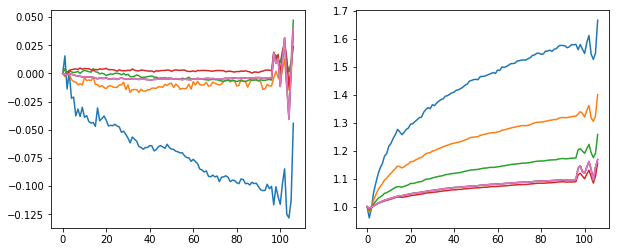

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [0]:
learn, run = get_learn_run(nfs,data,1.0,conv_layer,cbs=cbfs)

train: [0.2735567387846327, tensor(0.9152, device='cuda:0')]
valid: [0.1183497314453125, tensor(0.9641, device='cuda:0')]
train: [0.08299264219618335, tensor(0.9746, device='cuda:0')]
valid: [0.09068409423828125, tensor(0.9741, device='cuda:0')]
train: [0.059798486453970685, tensor(0.9816, device='cuda:0')]
valid: [0.0682453125, tensor(0.9798, device='cuda:0')]


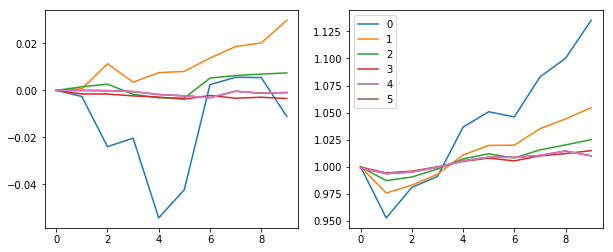

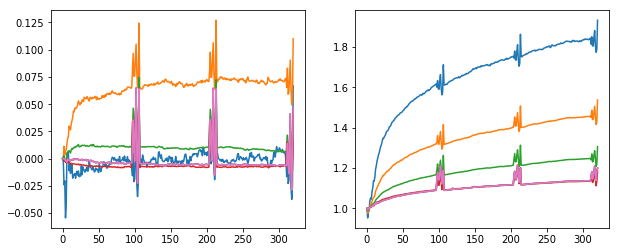

In [16]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(3, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [0]:
get_learn_run??

### builtin batch norm

In [0]:
#export
def conv_layer(ni,nf,ks=3,stride=2,bn=True,**kwargs):
  layers = [nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride,bias=not bn), GeneralRelu(**kwargs)]
  if bn: layers.append(nn.BatchNorm2d(nf,eps=1e-5,momentum=0.1))
  return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs,data,1.,conv_layer,cbs=cbfs)

In [20]:
%time run.fit(3,learn)

train: [0.3086989491256242, tensor(0.9031, device='cuda:0')]
valid: [0.0902184814453125, tensor(0.9723, device='cuda:0')]
train: [0.07838401106215015, tensor(0.9755, device='cuda:0')]
valid: [0.08713290405273437, tensor(0.9743, device='cuda:0')]
train: [0.054149155764235665, tensor(0.9831, device='cuda:0')]
valid: [0.058293310546875, tensor(0.9817, device='cuda:0')]
CPU times: user 2.76 s, sys: 475 ms, total: 3.23 s
Wall time: 3.27 s


### with scheduler

In [0]:
sched = combine_scheds([0.3,0.7], [sched_lin(0.6,2.),sched_lin(2.,0.1)])

In [0]:
learn,run = get_learn_run(nfs,data,0.9,conv_layer,cbs=cbfs+[partial(ParamScheduler,'lr',sched)])

train: [0.3256015384320131, tensor(0.9071, device='cuda:0')]
valid: [0.1150477294921875, tensor(0.9657, device='cuda:0')]
train: [0.09002554785345018, tensor(0.9713, device='cuda:0')]
valid: [0.103909228515625, tensor(0.9695, device='cuda:0')]
train: [0.06002520040138481, tensor(0.9806, device='cuda:0')]
valid: [0.06965994873046875, tensor(0.9791, device='cuda:0')]
train: [0.03773315174063457, tensor(0.9880, device='cuda:0')]
valid: [0.04988377380371094, tensor(0.9850, device='cuda:0')]
train: [0.023409799202201292, tensor(0.9927, device='cuda:0')]
valid: [0.04567722473144531, tensor(0.9878, device='cuda:0')]
train: [0.016459614960188718, tensor(0.9953, device='cuda:0')]
valid: [0.042639794921875, tensor(0.9874, device='cuda:0')]
train: [0.010233370913672693, tensor(0.9974, device='cuda:0')]
valid: [0.03818596801757813, tensor(0.9886, device='cuda:0')]
train: [0.007153252965396212, tensor(0.9987, device='cuda:0')]
valid: [0.0377807373046875, tensor(0.9892, device='cuda:0')]


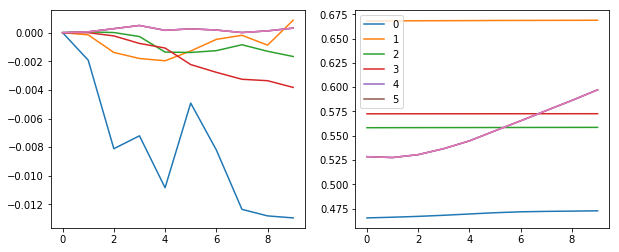

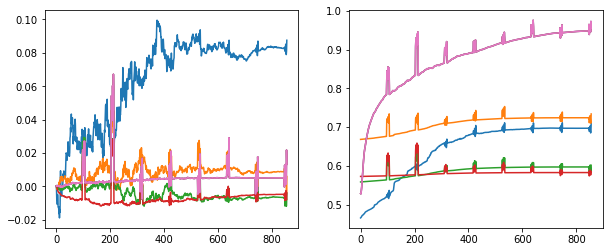

In [25]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(8, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### layer norm

In [0]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [0]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs,data,1.,conv_ln,cbs=cbfs)

In [30]:
%time run.fit(3,learn)

train: [nan, tensor(0.1090, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0988, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.5 s, sys: 441 ms, total: 3.94 s
Wall time: 3.98 s


###instance norm

In [0]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.std ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [0]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [34]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)
%time run.fit(3, learn)


train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0987, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.44 s, sys: 457 ms, total: 3.9 s
Wall time: 3.93 s


## fixing small batch sizes

In [0]:
data = DataBunch(*get_dls(train_ds,valid_ds,2),c)

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs,data,0.4,conv_layer,cbs=cbfs)

In [38]:
%time run.fit(1,learn)

train: [2.35202453125, tensor(0.1786, device='cuda:0')]
valid: [406448.2048, tensor(0.1542, device='cuda:0')]
CPU times: user 1min 14s, sys: 1.96 s, total: 1min 16s
Wall time: 1min 17s


####running batch norm

In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [43]:
%time run.fit(1, learn)

train: [0.3704375, tensor(0.9021, device='cuda:0')]
valid: [0.14879224853515624, tensor(0.9666, device='cuda:0')]
CPU times: user 2min 59s, sys: 3.74 s, total: 3min 3s
Wall time: 3min 4s


#### single epoch

In [0]:
data = DataBunch(*get_dls(train_ds,valid_ds,32),c)

In [0]:
learn,run = get_learn_run(nfs,data,0.9,conv_rbn,cbs=cbfs+[partial(ParamScheduler,'lr',sched_lin(1.,0.2))])

In [47]:
%time run.fit(1,learn)

train: [0.14995912949956486, tensor(0.9532, device='cuda:0')]
valid: [0.148377392578125, tensor(0.9801, device='cuda:0')]
CPU times: user 12.1 s, sys: 326 ms, total: 12.4 s
Wall time: 12.5 s
